In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dtreeviz.trees import dtreeviz

from src.eda import see_missing, plot_corr_heatmap
from src.preprocess import get_x_y
from src.evaluate import binary_cross_evaluate
from src.explain import get_feature_imp, get_permute_imp_df, plot_permute_imp
from src.model_supervised import find_dt_clf_max_depth

In [3]:
df = pd.read_csv('data/titanic_train.csv')

## EDA

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 12)

In [6]:
see_missing(df, only_missing=True)

,columns,total_missing,percent_missing
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467


In [7]:
plot_corr_heatmap(df)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
model_vars = ['Pclass', 'Fare', 'Survived']

## Preprocess

In [10]:
df_mod = df[model_vars]

In [11]:
X, y = get_x_y(df_mod, label_col='Survived')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)

## Fit Model

In [13]:
mod_rf = RandomForestClassifier(random_state=36)

In [14]:
_ = mod_rf.fit(X_train, y_train)

In [15]:
binary_cross_evaluate(X_train, y_train, mod_rf)

,fit_time,score_time,test_accuracy,test_f1
0,0.147837,0.015696,0.739910,0.628205
1,0.115796,0.012019,0.681614,0.489209
2,0.110315,0.011685,0.671171,0.482270


## Explain the Model

### Random Forest Feature Importance

In [16]:
get_feature_imp(X_train, mod_rf)

,name,score
0,Fare,0.867004
1,Pclass,0.132996


### Permutation Feature Importance

In [17]:
df_permute, permute_result = get_permute_imp_df(mod_rf, X_test, y_test, return_full_result=True)

In [18]:
df_permute

,name,importance_mean,importance_std
0,Fare,0.122870,0.014067
1,Pclass,0.058296,0.020647


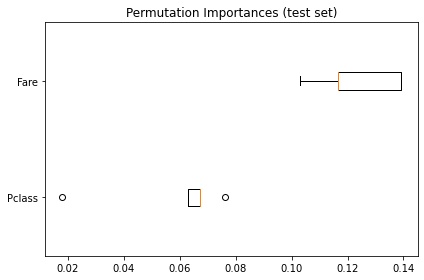

In [19]:
plot_permute_imp(X_test, permute_result)

### Surrogate Tree

In [20]:
y_train_surr = mod_rf.predict(X_train)

In [21]:
cv_dt_acc = find_dt_clf_max_depth(X_train, y_train, max_depth_range=range(1, 20))
cv_dt_acc

array([0.64374015, 0.67363552, 0.66319234, 0.66466018, 0.68409216,
       0.69157947, 0.68261086, 0.66913775, 0.68711537, 0.69156601,
       0.69458247, 0.69607724, 0.70207652, 0.69907351, 0.69758548,
       0.69758548, 0.69757874, 0.69757874, 0.69608398])

In [22]:
mod_dt_surr = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train_surr)

In [23]:
mod_dt_surr

DecisionTreeClassifier(max_depth=3)

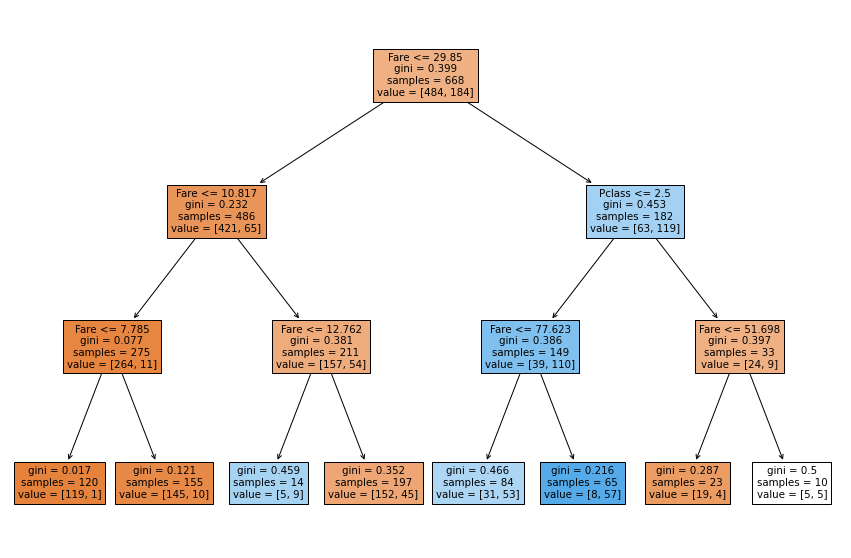

In [24]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(mod_dt_surr, feature_names=X_test.columns, filled=True)